In [97]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import poisson, nbinom
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import sys, os
from pypdf import PdfMerger

In [4]:
# estimate recall for a given data frame (data) and parameters (param)
# data:
#    data is a pandas DataFrame, sorted by scores from high to low
#    data has a column 'Score': classifier-predicted score
#    data has a column 'Label': 1: relevant; 0: non-relevant; -1: unlabeled 
# param:
#    param is a dictionary

#        'ignore_score': bool
#        if not 'ignore_score':
#            'score_threshold': double [0.0, 1.0]
#        'interval_length': int, >= 1
#        'rate_curve': {'exp', 'poly', 'exp_poly', 'const'}
#        'lookback': int, >= 1
#        'forget_factor': double, >= 0
#        'est_num_rel': {'all', 'rest'}
#        'confidence_bound': {'none', 'poisson'}
#        'confidence_level': double [0.0, 1.0]
#

In [5]:
# processes the 'Label' and 'Score' columns of the input data
# such that each reference has a guessed/pseudo inclusion/exclusion label
# 1 means inclusion, 0 means exclusion
# if param['ignore_score'] is True, 
#     then we assign all unlabeled data a pseudo exclusion label
# if param['ignore_score'] is False,
#     then we assign an unlabeled data point a pseudo inclusion label 
#     if it has a predicted score no less than param['score_threshold']
#     otherwise, we assign an unlabeled data point a pseudo exclusion label
# 
# params:
#     data: input pandas DataFrame
#     param: global parameter dictionary
# return:
#     a list of pseudo labels
#     1: inclusion; 0: exclusion

def get_inclusion_list(data, param):
    l = []
    if param['ignore_score']:
        for i, row in data.iterrows():
            if row['Label'] < 0:
                l.append(0)
            else:
                l.append(row['Label'])
    else:
        for i, row in data.iterrows():
            if row['Label'] < 0:
                if row['Score'] >= param['score_threshold']:
                    l.append(1)
                else:
                    l.append(0)
            else:
                l.append(row['Label'])
    return l    

In [6]:
# exponential rate function 
# x: position index, starting from 1
# a: function parameter, to be determined by curve-fitting
# a should be greater than 0. large a means fast rate decay 
# rate = exp^{-a * (position - 1)}

def exponential_rate(x, a):
    return np.exp(-a * (x - 1))

In [7]:
# polynomial rate function 
# x: position index, starting from 1
# a: function parameter, to be determined by curve-fitting
# a should be greater than 0. large a means fast rate decay 
# rate = position^{-a}

def polynomial_rate(x, a):
    return np.power(x, -a)

In [8]:
# mixture of exponential and polynomial rate function 
# x: position index, starting from 1
# a1: exponential function parameter, to be determined by curve-fitting
# a1: polynomial function parameter, to be determined by curve-fitting
# c: weight of exponential. (1-c): weight of polynomial
# a1, a2 should be greater than 0. large a1, a2 means fast rate decay
# c should be between 0 and 1.
# rate = c * exp^{-a * (position - 1)}  +  (1-c) * position^{-a}

def exp_poly_rate(x, a1, a2, c):
    return c * np.exp(-a1 * (x - 1)) + (1-c) * np.power(x, -a2)

In [9]:
# constant rate function 
# x: position index, starting from 1
# a: function parameter, to be determined by curve-fitting
# a should be greater than 0. larger a means high inclusion rate 
# rate = a, for all positions

def constant_rate(x, a):
    return a * np.ones_like(x)

In [10]:
# helper function used in fit_inclusion_rate_ls
# travel back from the end of y's, until we see param['lookback'] 
# inclusions. return the travel length

def get_lookback_travel_length(y_list, lookback):
    num_rel_so_far = 0
    # traverse the y_list in reverse order
    for i in range(1, len(y_list) + 1):
        if y_list[-i] > 0:
            num_rel_so_far += 1
        if num_rel_so_far == lookback:
            return i
    return len(y_list)

In [11]:
# helper function used in fit_inclusion_rate_ls
# smooth x's and y's by averaging y's in equal-length intervals
# smoothing helps mitigate overfitting when the rate function
# is not constant.
# smoothing is not needed when the rate function is a constant.

def smooth(x, y, param):
    interval_length = param['interval_length']
    if len(x) <= interval_length:
        return [np.average(x)], [np.average(y)]
    
    new_x, new_y = [], []
    num_intervals = int(len(x) / interval_length)
    interval_multiples = num_intervals * interval_length
    start_pos = 0
    
    for i in range(num_intervals):
        new_x.append( sum(x[start_pos : start_pos+interval_length])/interval_length )
        new_y.append( sum(y[start_pos : start_pos+interval_length])/interval_length )
        start_pos += interval_length
    
    if len(x) > interval_multiples:
        new_x.append( sum(x[interval_multiples:]) / (len(x) - interval_multiples) )
        new_y.append( sum(y[interval_multiples:]) / (len(x) - interval_multiples) )
    
    return new_x, new_y

In [12]:
# fit inclusion rate using nonlinear least square curve-fitting
# params:
#    inc_list: inclusion list, same length as the input dataframe
#              each entry is a pseudo inclusion label (1 or 0)
#    curr_pos: current position, an index in [0, len(inc_list)-1]
#              the current screening position. we will only use
#              the inc_list before curr_pos to fit a rate function
#    param:    global parameter dictionary
# return:
#    rate: a list with equal length as inc_list
#              each entry is an estimated probability of inclusion

def fit_inclusion_rate_ls(inc_list, curr_pos, param):
    # prepare the list of x's and y's for curve fitting
    x, y = [], []
    
    # first, take out pseudo labels from inc_list up to curr_pos
    # for example:
    # inc_list:     1 0 1 1 0 ... 0   1   0            0   0   ...   0
    # position:     1 2 3 4 5 ... 118 119 curr_pos=120 121 122 ...   end
    #               |<------- considered ----------->|
    for i in range(curr_pos):
        x.append( i + 1 )
        y.append( inc_list[i]  )
    
    # if no relevant articles from beginning to curr_pos
    # let's don't give up so quickly. assume there were
    # one relevant document at the beginning
    #
    # TODO: add heuristic method to detect if:
    #       1) the inclusion rate is too low 
    #       2) the ranker seems to perform worse than random
    # if so, switch to conservative rate estimates
    #
    if sum(y) == 0:
        y[0] = 1
    
    # print ('full_x', x)
    # print ('full_y', y)
    
    # travel back from the end of y's, until we see param['lookback'] 
    # inclusions. return the travel length
    travel_length = get_lookback_travel_length(y, param['lookback'])
    
    # only take the most recent x's and y's within travel_length
    # for example: travel_length = 117
    # inc_list:     1 0 1 1 0 ... 0   1   0            0   0   ...   0
    # position:     1 2 3 4 5 ... 118 119 curr_pos=120 121 122 ...   end
    #                     |<---- considered -------->| 
    x, y = x[-travel_length:], y[-travel_length:]
    
    # print ('recent_x', x)
    # print ('recent_y', y)
    
    # smooth x's and y's by averaging y's in equal-length intervals
    # smoothing helps mitigate overfitting when the rate function
    # is not constant.
    # smoothing is not needed when the rate function is a constant.
    x, y = smooth(x, y, param)
    
    # print ('smooth_x', x)
    # print ('smooth_y', y)
    
    if param['rate_curve'] == 'exp':
        func = exponential_rate
    elif param['rate_curve'] == 'poly':
        func = polynomial_rate
    elif param['rate_curve'] == 'const':
        func = constant_rate
    elif param['rate_curve'] == 'exp_poly':
        func = exp_poly_rate
    
    # the i-th entry in sigma_list indicates the importance 
    # of the i-th (x,y) data point in curve fitting
    # the larger sigma, the less important a data point
    # we set the sigma to be larger for data points that are
    # 'further back in the past', i.e., to the left of the x's and y's
    # this achieves a forgetting effect: 
    # the further back an inclusion event, the less influence it has 
    # on estimating the rate function 
    
    # here, we implement the sigma_list as an increasing function
    # with respect to the reversed position of a data point, so:
    #    the most recent data point has sigma = 1 
    #    the second most recent data point has sigma slightly larger than 1
    #    and so on.
    #
    # param['forget_factor'] controlls how fast the forgetting is.
    # param['forget_factor'] = 0: no forgetting
    # param['forget_factor'] > 0: the larger the value, the faster the forgetting.
    
    # sigma_list = 1 + param['forget_factor'] / 1000 * np.power(np.array(range(1, len(x)+1)), 2)
    sigma_list = np.exp(param['forget_factor'] / 50 * np.array(range(len(x))))
    sigma_list = np.flip(sigma_list)
    # print ('sigma_list', sigma_list)
    
    # fit the rate function using the most recent x's and y's with forgetting
    if param['rate_curve'] == 'exp' or param['rate_curve'] == 'poly' or param['rate_curve'] == 'const': 
        popt, pcov = curve_fit(func, x, y, sigma = sigma_list, maxfev = 500)
    elif param['rate_curve'] == 'exp_poly':
        popt, pcov = curve_fit(func, x, y, sigma = sigma_list, maxfev = 500, bounds=(0, [np.inf, np.inf, 1.0]))
    
    # use the fitted curve to generate the rates at each position 
    x_array = np.array(range(1, len(inc_list)+1))
    rate = func(x_array, *popt)
    
    # print ('popt', *popt)
    # print (rate)

    
    # plt.plot(x, y, 'b-', label='data for fitting')
    # if param['rate_curve'] == 'exp' or param['rate_curve'] == 'poly' or param['rate_curve'] == 'const':
    #    plt.plot(x_array, rate, 'r-', label='fit: a=%5.3f' % tuple(popt))
    # else:
    #    plt.plot(x_array, rate, 'r-', label='fit: a1=%5.3f, a2=%5.3f, c=%5.3f' % tuple(popt))
    # plt.xlabel('rank position')
    # plt.ylabel('inclusion rate')
    # plt.ylim([0, 1])
    # plt.legend()
    # plt.show()
    
    return rate

In [13]:
# recall is a ratio:
#               number of included documents so far
#               ----------------------------------------- 
#               total number of documents to be included 
# we know the denominator, by counting included documents so far
# we can estimate the denominator in two ways:
# 1) param['est_num_rel'] == 'all':
#    total number of documents estimated to be included
# 2) param['est_num_rel'] == 'rest':
#    number of included documents so far 
#       + number of *unlabeled* documents estimated to be included

def take_ratio(data, rate, param):
    num_rel = len(data[data['Label'] == 1]) + 1e-20
    if param['est_num_rel'] == 'all':
        est_num_rel_all = sum(rate)
        if param['confidence_bound'] == 'none':
            denominator = est_num_rel_all
        elif param['confidence_bound'] == 'poisson':
            denominator = poisson.ppf(param['confidence_level'], est_num_rel_all)
        else: # param['confidence_bound'] == 'none'
            denominator = est_num_rel_all
        return num_rel / denominator
    else: # param['est_num_rel'] == 'rest':
        est_num_rel_rest = sum([rate[i] for i, row in data.iterrows() if row['Label'] == -1])
        # print ('est_num_rel_rest', est_num_rel_rest)
        if param['confidence_bound'] == 'none':
            partial_denominator = est_num_rel_rest
        elif param['confidence_bound'] == 'poisson':
            partial_denominator = poisson.ppf(param['confidence_level'], est_num_rel_rest)
        else: # param['confidence_bound'] == 'none'
            partial_denominator = est_num_rel_rest
        return num_rel / (num_rel + partial_denominator)

In [14]:
def estimate_recall(data, current_position, param):
    
    # inclusion_list is a Python list that has equal length as data
    # it processes the 'Label' and 'Score' columns of the input data
    # such that each reference has a *guessed* inclusion/exclusion label
    # 1 means inclusion, 0 means exclusion
    inclusion_list = get_inclusion_list(data, param)
    
    # rate is a Python list that has equal length as data
    # each value in the list is an estimated rate 
    # (i.e., probability) of inclusion
    rate = fit_inclusion_rate_ls(inclusion_list, current_position, param)
    
    # calculate recall using the estimated rate from above
    recall_est = take_ratio(data, rate, param)
    
    return recall_est

# Testing Recall Estimation Methods

In [40]:
# produce a data table for plotting:
# cut_off, num_rel, true_recall, est1, est2
def generate_plot_data(all_data, param_dict, step_size, data_path):
    out_f = open(data_path, 'w')
    out_f.write('\t'.join(['cut_off', 'num_rel', 'true_recall']))
    for method_name, param in params.items():
        out_f.write('\t' + method_name)
    out_f.write('\n')
        
    num_rel = 0
    total_rel = len(all_data[all_data['Label'] == 1])
    for i, row in all_data.iterrows():
        if row['Label'].item() == 1:
            num_rel += 1
        if i % step_size == 0 and i > 0:
            cutoff = i
            all_data_copy = all_data.copy()
            for j, row in all_data_copy.iterrows():
                if j > cutoff:
                    all_data_copy.at[j,'Label'] = -1
            
            true_r = num_rel / total_rel
            est_r_list = []
            for method_name, param in params.items():
                est_r = estimate_recall(all_data_copy, cutoff, param)
                est_r_list.append(est_r)
                
            out_f.write('\t'.join([str(i), str(num_rel), str(true_r)]))
            for est_r in est_r_list:
                out_f.write('\t' + str(est_r))
            out_f.write('\n')
            
            if min(est_r_list) > 0.99:
                break
    out_f.close()

In [119]:
def plot_true_and_estimated_recall_curves(all_data, plot_data, params, source, topic, num_screened, plot_path):
    total_rel = len(all_data[all_data['Label'] == 1])
    plot_data_df = pd.read_csv(plot_data, sep = '\t')
    
    cut_off = plot_data_df['cut_off'].tolist()
    true_recall = plot_data_df['true_recall'].tolist()
    
    # plot the oscillating curves
    plt.title('{}, {}, rel: {}, screened: {}, S: {}'.format(source, topic, total_rel, num_screened, len(all_data)))
    plt.plot(cut_off, true_recall, 'r', label='true recall')
    for method_name, param in params.items():
        plt.plot(cut_off, plot_data_df[method_name].tolist(), LINE_COLOR[method_name], label = method_name, linewidth=0.75)
    
    plt.grid()
    plt.axhline(y = 0.95, color = 'magenta', linestyle = '--')

    plt.legend(loc = 'lower right')
    plt.xlabel('Rank position')
    plt.ylabel('Recall')
    plt.savefig(plot_path)
    plt.show()

In [ ]:
def plot_one_snapshot(rel_pos, cutoff, row_idx, true_recall, esti_recall, data_size, plot_path):
    rel_pos_i = [rp for rp in rel_pos if rp <= cutoff]
    num_rel = len(rel_pos_i)
    total_rel = len(rel_pos)
    plt.title('{}, {}, rel: {}, screened: {}, S: {}'.format(source, topic, total_rel, num_screened, data_size))
    plt.plot(rel_pos_i + [cutoff], [(k+1)/total_rel for k in range(num_rel)] + [true_recall[row_idx]], 'r', label = 'true recall')
    for method_name, param in params.items():
        est_r = esti_recall[method_name][row_idx]
        est_total_rel = num_rel / est_r
        plt.plot(rel_pos_i + [cutoff], [(k+1)/est_total_rel for k in range(num_rel)] + [est_r], LINE_COLOR[method_name], label = method_name, linewidth=1)
    
    plt.grid()
    plt.axhline(y = 0.95, color = 'magenta', linestyle = '--')
    plt.legend(loc = 'lower right')
    plt.xlabel('Rank position')
    plt.xlim(0, data_size)
    plt.ylabel('Recall')
    plt.ylim(0, 1.05)
    plt.savefig(plot_path)
    plt.show()

In [105]:
def plot_recall_curves_snapshots(all_data, plot_data, params, source, topic, num_screened, num_snapshots, plot_path_prefix):

    total_rel = len(all_data[all_data['Label'] == 1])
    rel_pos = []
    for i, row in all_data.iterrows():
        if row['Label'].item() == 1:
            rel_pos.append(i + 1)
            
    plot_data_df = pd.read_csv(plot_data, sep = '\t')
    
    cut_off = plot_data_df['cut_off'].tolist()
    true_recall = plot_data_df['true_recall'].tolist()
    esti_recall = {}
    for method_name, param in params.items():
        esti_recall[method_name] = plot_data_df[method_name].tolist()
        
    step_size = int(np.round(len(cut_off) / num_snapshots))
    
    for j in range(num_snapshots - 1):
        row_idx = j  * step_size
        i = cut_off[row_idx]
        plot_path = plot_path_prefix + '_{}.pdf'.format(i)
        plot_one_snapshot(rel_pos, i, row_idx, true_recall, esti_recall, len(all_data), plot_path)
        
    row_idx = len(cut_off) - 1
    i = cut_off[-1]
    plot_path = plot_path_prefix + '_{}.pdf'.format(i)
    plot_one_snapshot(rel_pos, i, row_idx, true_recall, esti_recall, len(all_data), plot_path)

# Baseline: SWIFT; Forget Factors: 0.1, 0.2, 0.5

In [55]:
param_forget_01 = {'ignore_score': True,
         'interval_length': 2,
         'lookback': 5,
         'forget_factor': 0.1,
         'rate_curve': 'const',
         'est_num_rel': 'rest',
         'confidence_bound': 'poisson',
         'confidence_level': 0.95
        }

param_forget_02 = {'ignore_score': True,
         'interval_length': 2,
         'lookback': 5,
         'forget_factor': 0.2,
         'rate_curve': 'const',
         'est_num_rel': 'rest',
         'confidence_bound': 'poisson',
         'confidence_level': 0.95
        }

param_forget_05 = {'ignore_score': True,
         'interval_length': 2,
         'lookback': 5,
         'forget_factor': 0.5,
         'rate_curve': 'const',
         'est_num_rel': 'rest',
         'confidence_bound': 'poisson',
         'confidence_level': 0.95
        }

param_swift = {'ignore_score': True,
         'interval_length': 2,
         'lookback': 5,
         'forget_factor': 0,
         'rate_curve': 'const',
         'est_num_rel': 'rest',
         'confidence_bound': 'none',
         'confidence_level': 0.95
        }

params = {'SWIFT': param_swift, 'SWIFT+forget0.1': param_forget_01, 'SWIFT+forget0.2': param_forget_02, 'SWIFT+forget0.5': param_forget_05}

LINE_COLOR = {'SWIFT': 'tab:green', 'SWIFT+forget0.1': 'tab:cyan', 'SWIFT+forget0.2': 'tab:blue', 'SWIFT+forget0.5': 'tab:orange'}


ASREVIEW, STcardioCHE2, screened: 210


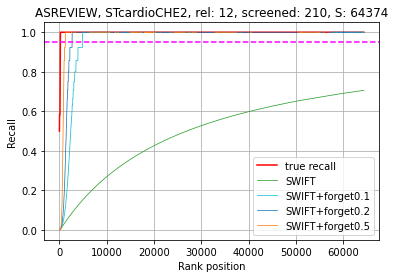

SWIFT, AquaPb2021, screened: 8183


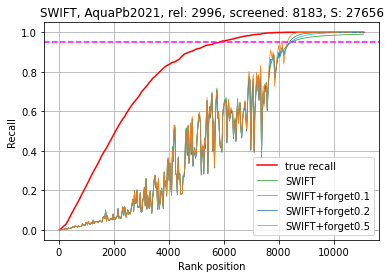

ASREVIEW, LTmortEpi2, screened: 392


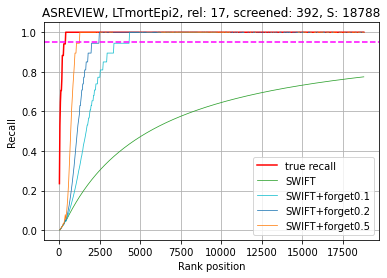

SWIFT, Ozone2022, screened: 204


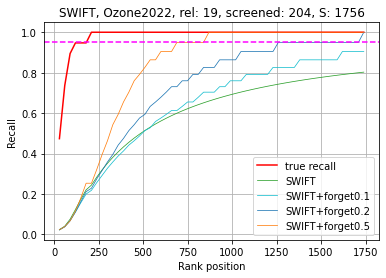

SWIFT, BiogeoPb2021, screened: 628


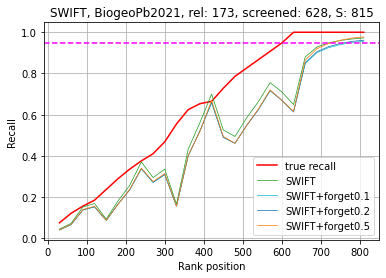

SWIFT, TerrPb2021, screened: 6836


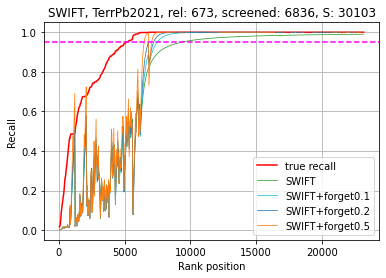

ASREVIEW, STcardioepi1, screened: 868


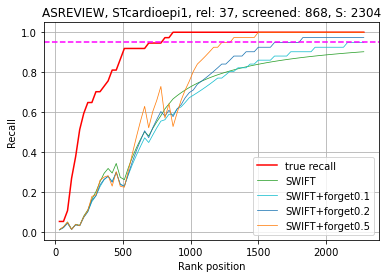

ASREVIEW, Reproepi1, screened: 588


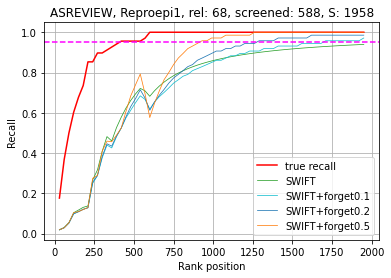

ASREVIEW, STrespCHE1, screened: 593


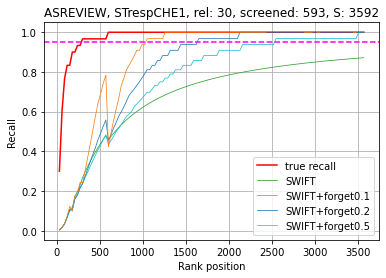

ASREVIEW, STcardioCHE1, screened: 78


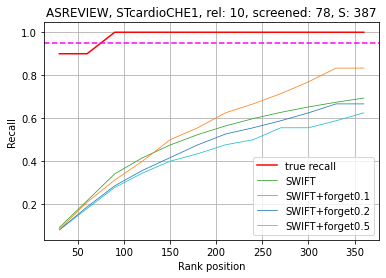

SWIFT, TerrPb2022, screened: 1826


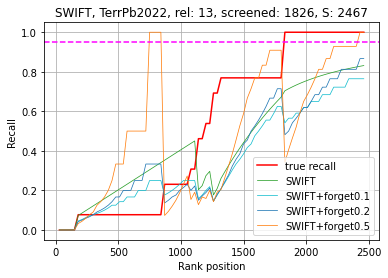

SWIFT, EpiPb2021, screened: 4213


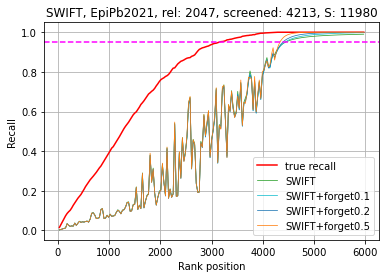

SWIFT, ExposPb2021, screened: 9340


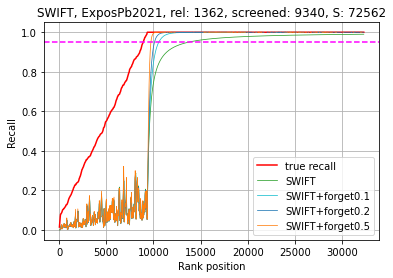

SWIFT, AquaPb2022, screened: 1688


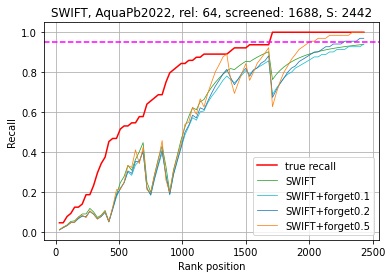

SWIFT, EpiPb2022, screened: 1074


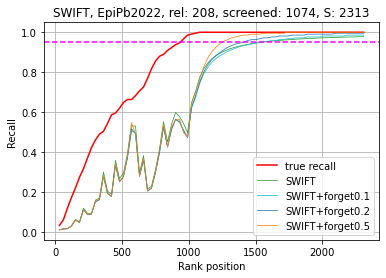

CITLINK, PM2022, screened: 554


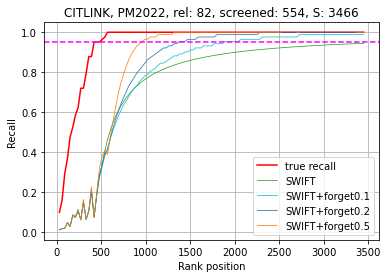

In [59]:
per_topic_data_folder = '../data/per_topic_simulation'
per_topic_output_folder = '../output/per_topic_results'

for file in os.listdir(per_topic_data_folder):
    file_path = os.path.join(per_topic_data_folder, file)
    source, topic, num_screened = file.split('.')[0].split('_')
    num_screened = int(num_screened)
    rank_dataframe = pd.read_csv(file_path)
    data_path = os.path.join(per_topic_output_folder, file.replace('.csv', '.txt'))
    
    print ('{}, {}, screened: {}'.format(source, topic, num_screened))
    
    generate_plot_data(rank_dataframe, params, 30, data_path)

ASREVIEW, STcardioCHE2, screened: 210


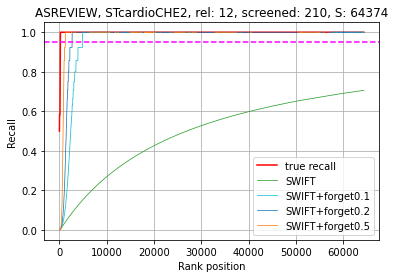

SWIFT, AquaPb2021, screened: 8183


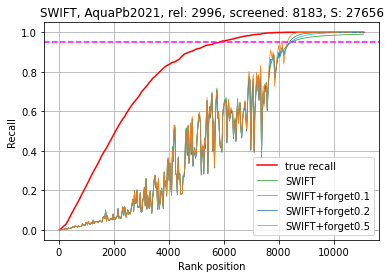

ASREVIEW, LTmortEpi2, screened: 392


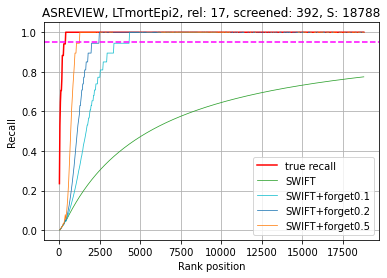

SWIFT, Ozone2022, screened: 204


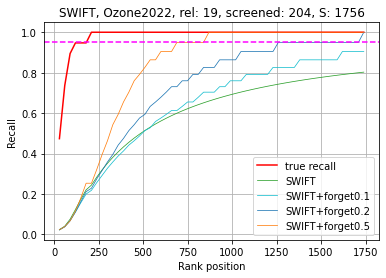

SWIFT, BiogeoPb2021, screened: 628


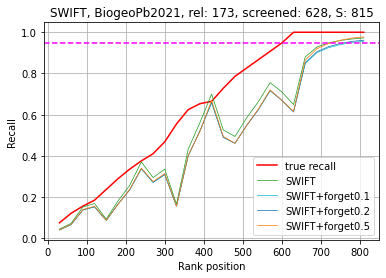

SWIFT, TerrPb2021, screened: 6836


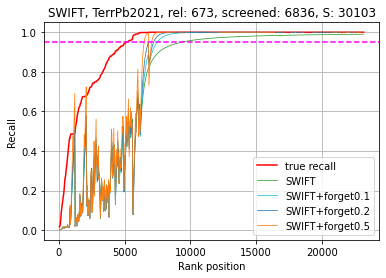

ASREVIEW, STcardioepi1, screened: 868


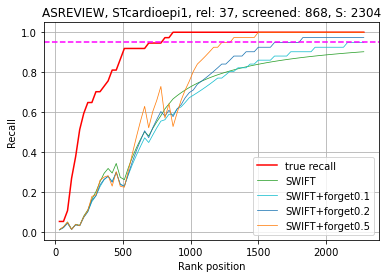

ASREVIEW, Reproepi1, screened: 588


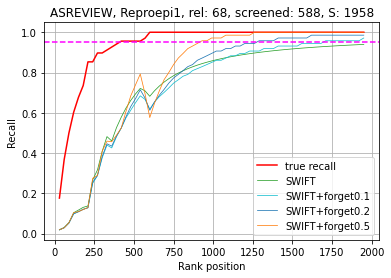

ASREVIEW, STrespCHE1, screened: 593


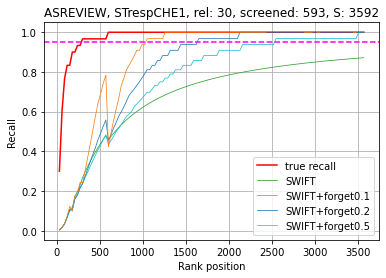

ASREVIEW, STcardioCHE1, screened: 78


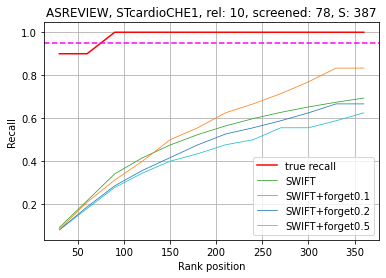

SWIFT, TerrPb2022, screened: 1826


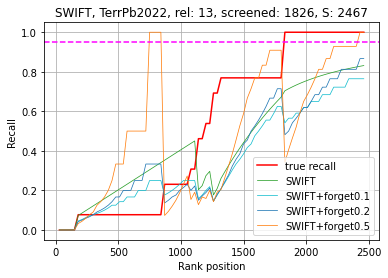

SWIFT, EpiPb2021, screened: 4213


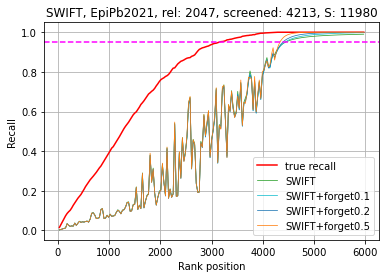

SWIFT, ExposPb2021, screened: 9340


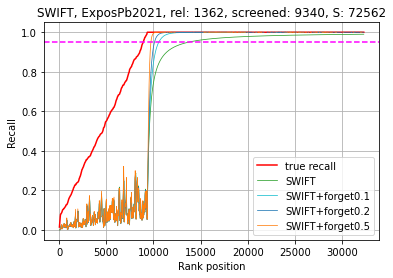

SWIFT, AquaPb2022, screened: 1688


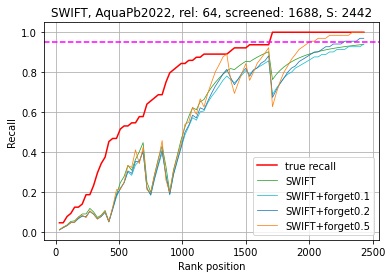

SWIFT, EpiPb2022, screened: 1074


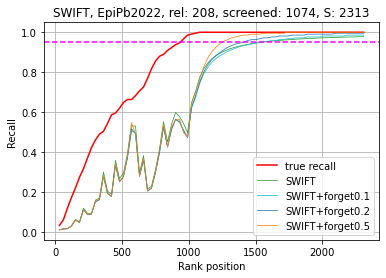

CITLINK, PM2022, screened: 554


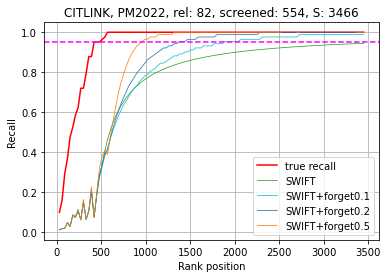

In [122]:
per_topic_data_folder = '../data/per_topic_simulation'
per_topic_output_folder = '../output/per_topic_results.2'

for file in os.listdir(per_topic_data_folder):

    file_path = os.path.join(per_topic_data_folder, file)
    source, topic, num_screened = file.split('.')[0].split('_')
    num_screened = int(num_screened)
    rank_dataframe = pd.read_csv(file_path)
    data_path = os.path.join(per_topic_output_folder, file.replace('.csv', '.txt'))
    
    print ('{}, {}, screened: {}'.format(source, topic, num_screened))
    
    plot_path = os.path.join(per_topic_output_folder, file.replace('.csv', '_recall_trajectory.pdf'))
    plot_true_and_estimated_recall_curves(rank_dataframe, data_path, params, source, topic, num_screened, plot_path)
    

ASREVIEW, STcardioCHE2, screened: 210


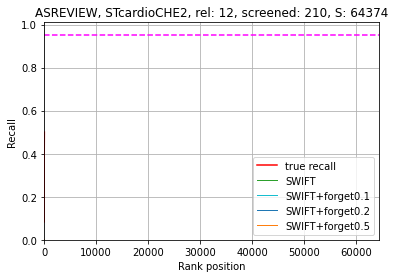

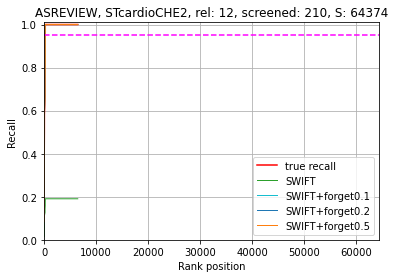

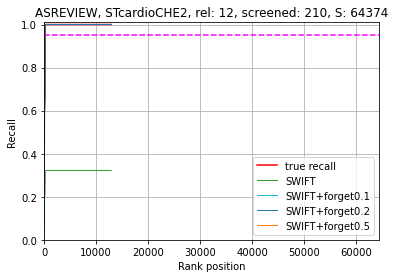

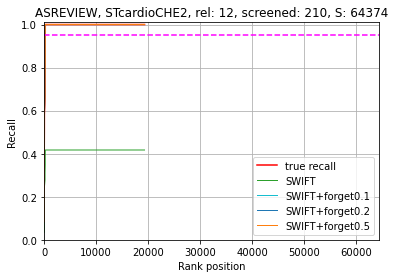

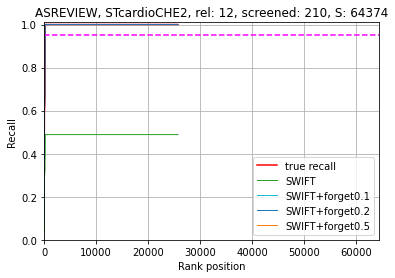

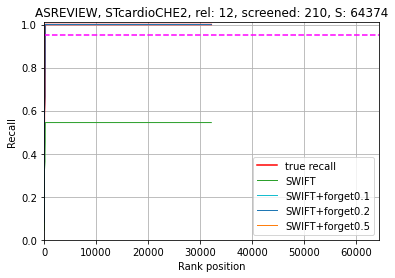

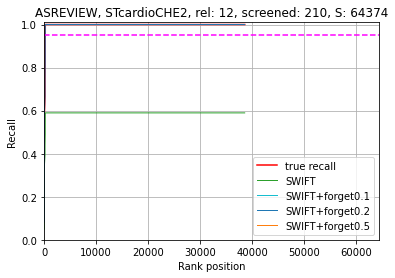

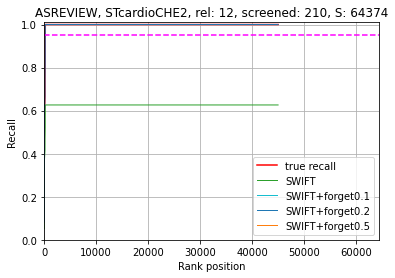

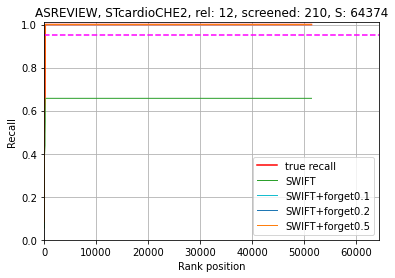

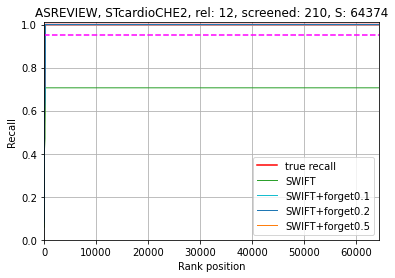

SWIFT, AquaPb2021, screened: 8183


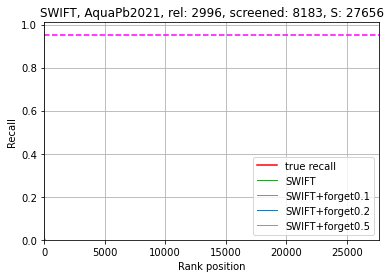

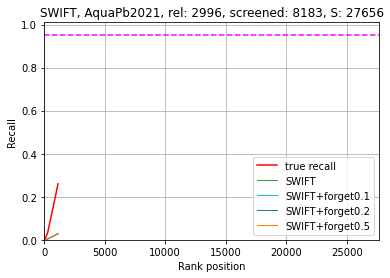

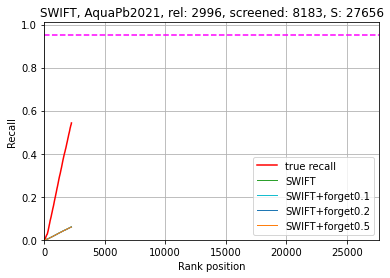

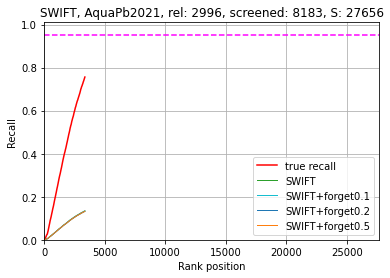

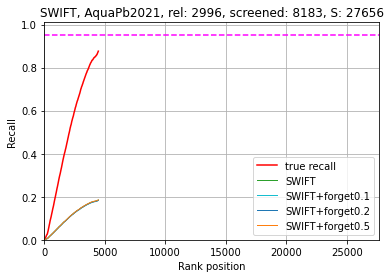

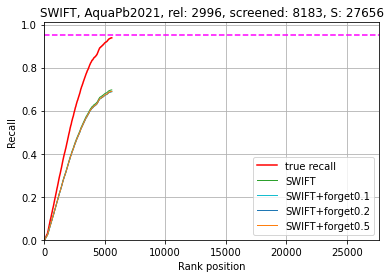

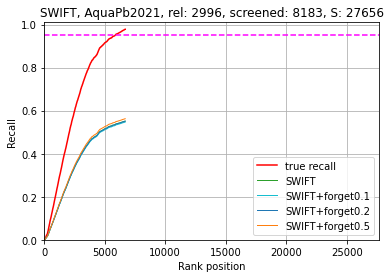

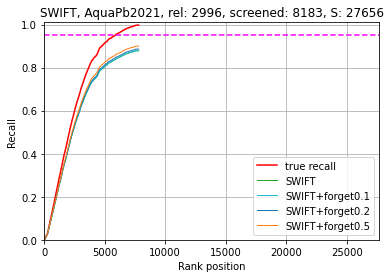

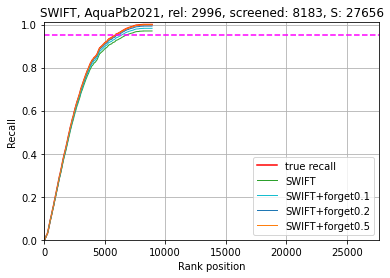

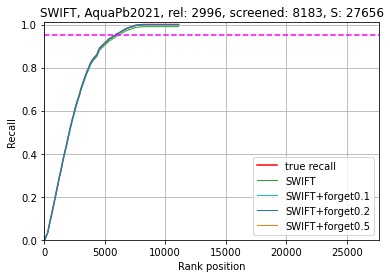

ASREVIEW, LTmortEpi2, screened: 392


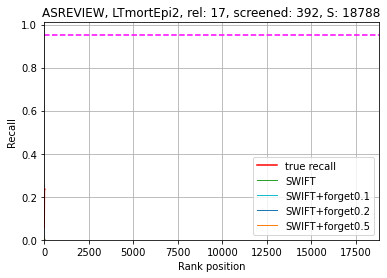

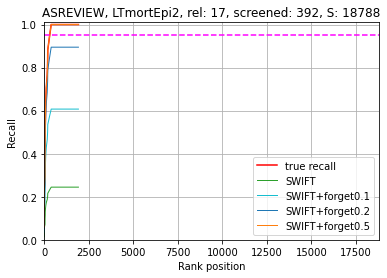

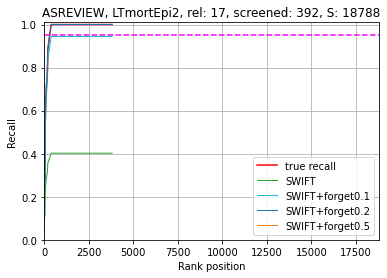

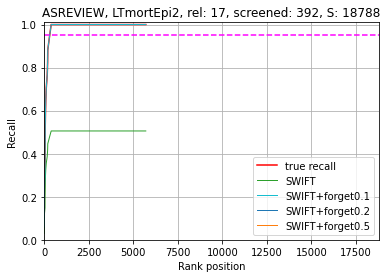

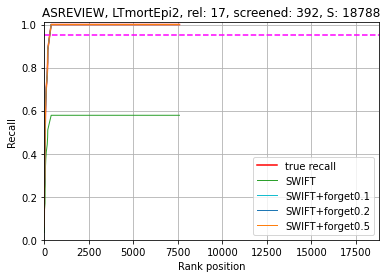

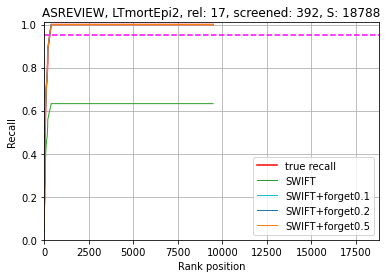

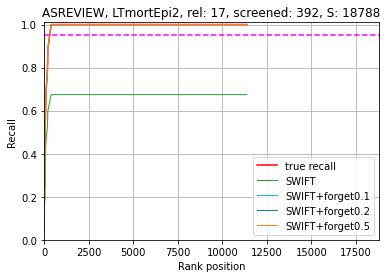

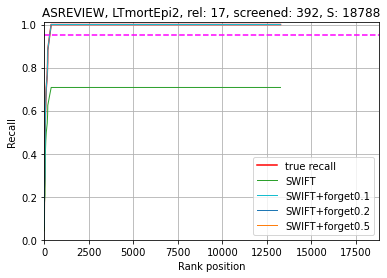

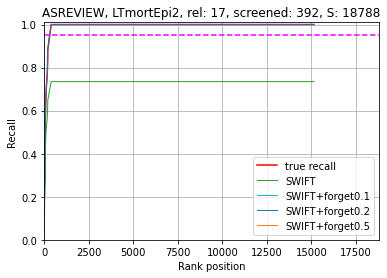

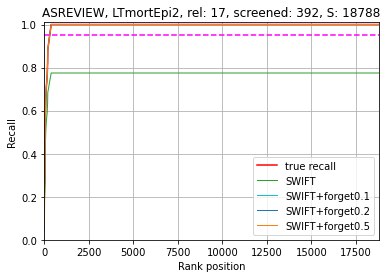

SWIFT, Ozone2022, screened: 204


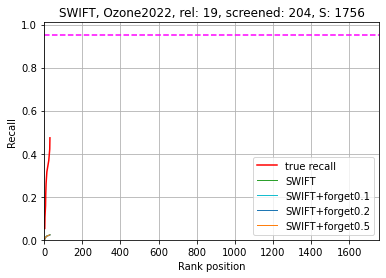

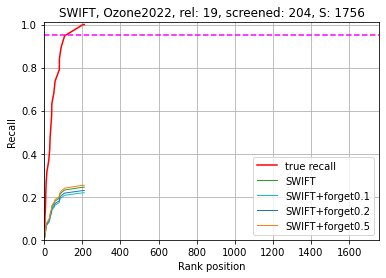

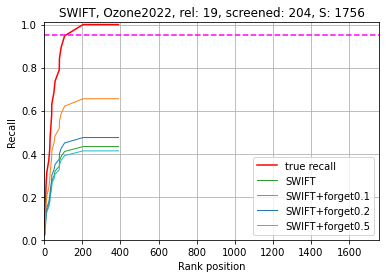

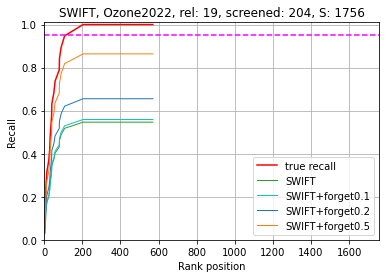

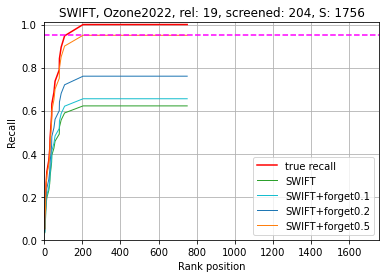

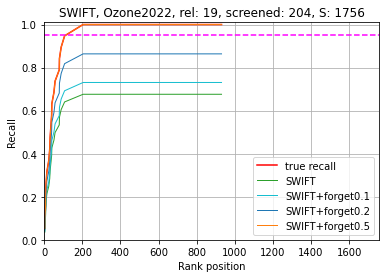

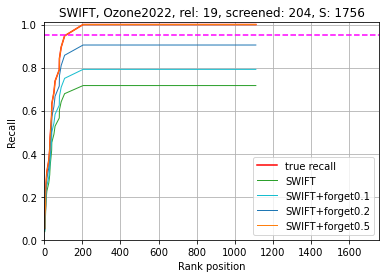

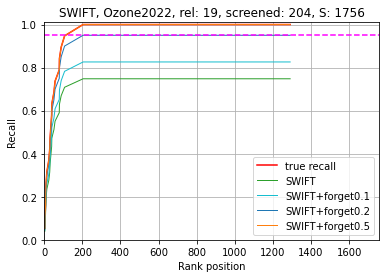

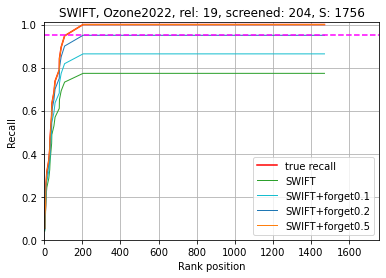

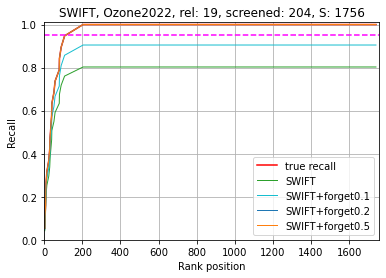

SWIFT, BiogeoPb2021, screened: 628


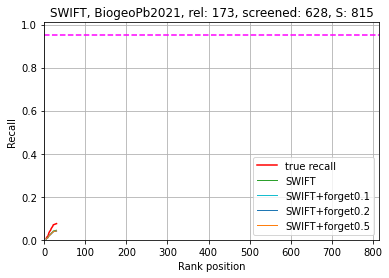

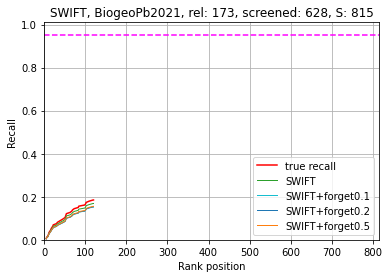

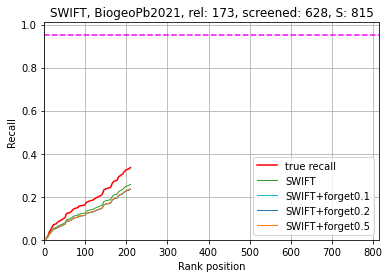

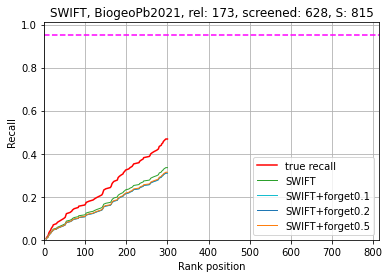

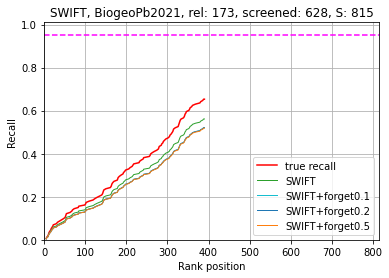

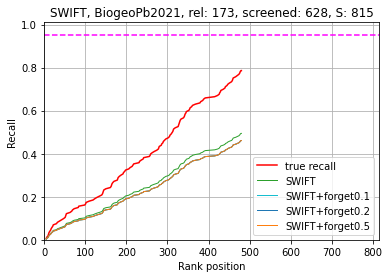

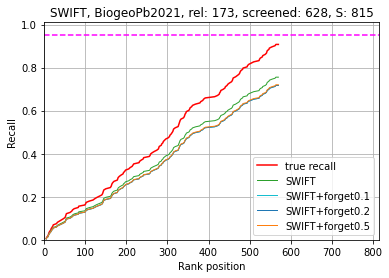

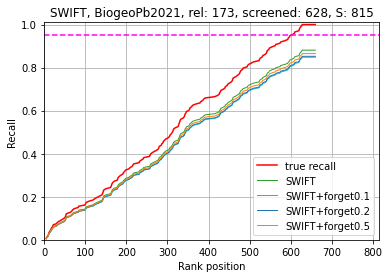

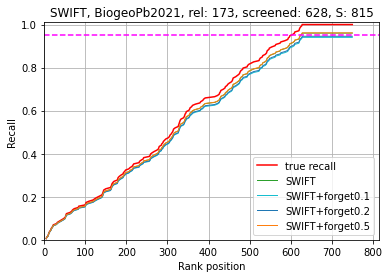

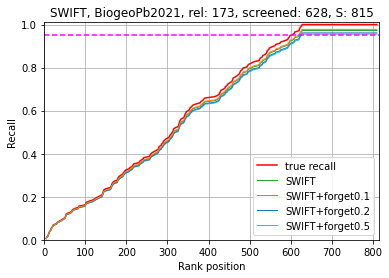

SWIFT, TerrPb2021, screened: 6836


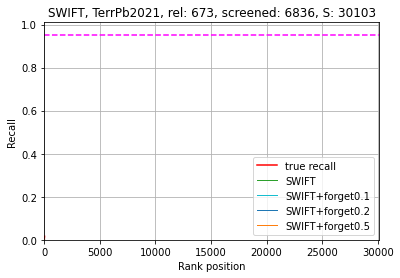

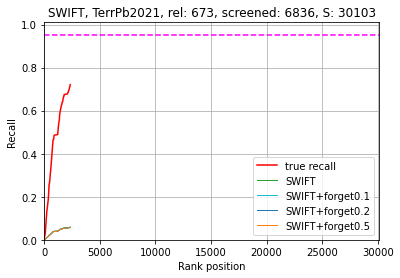

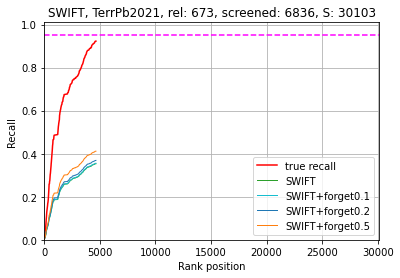

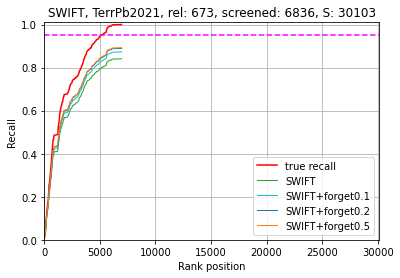

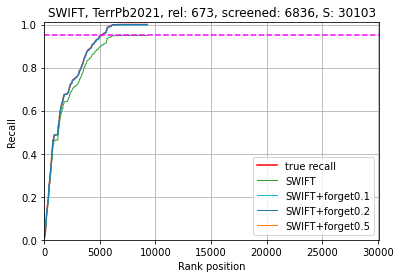

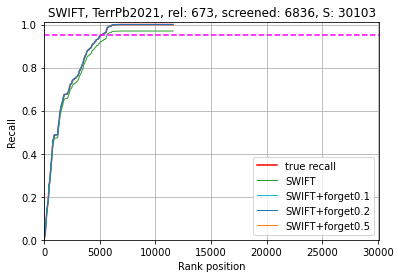

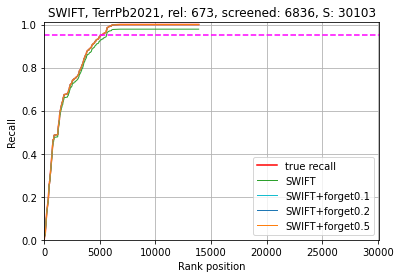

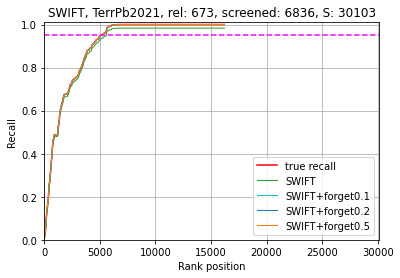

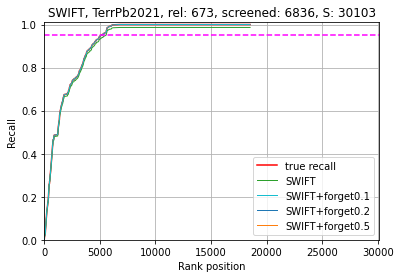

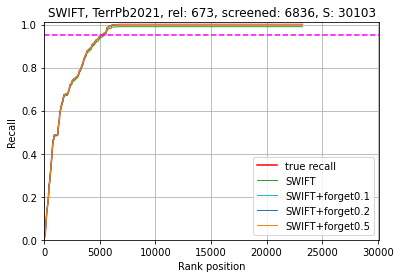

ASREVIEW, STcardioepi1, screened: 868


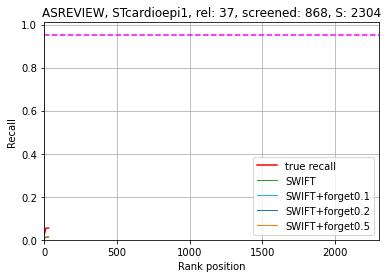

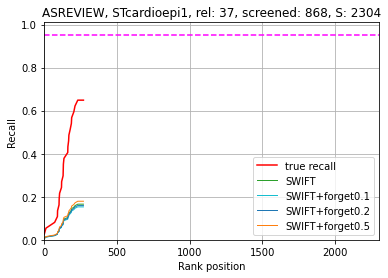

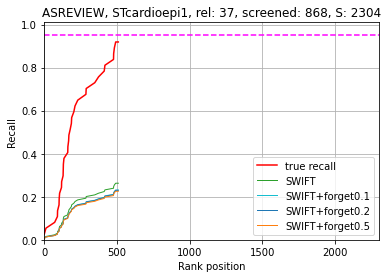

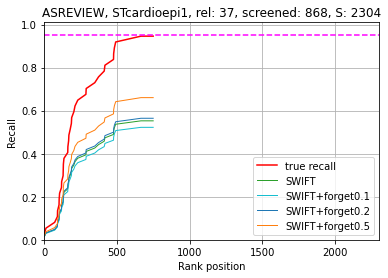

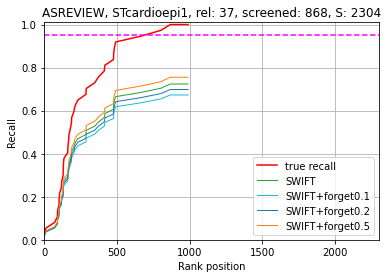

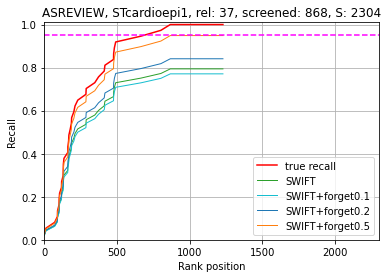

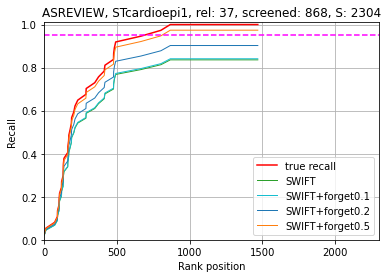

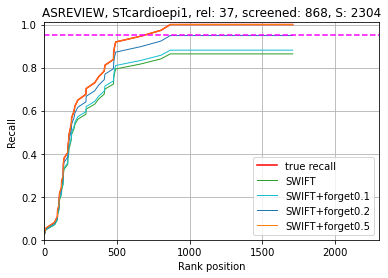

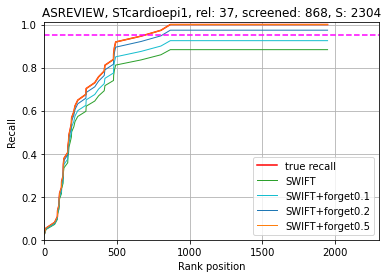

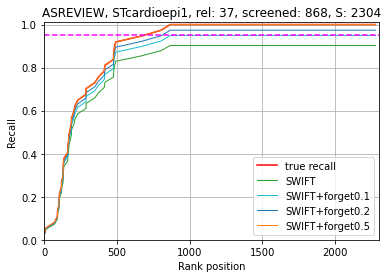

ASREVIEW, Reproepi1, screened: 588


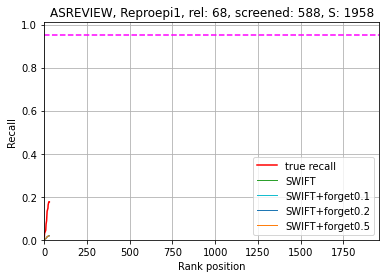

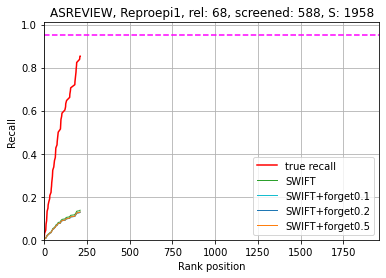

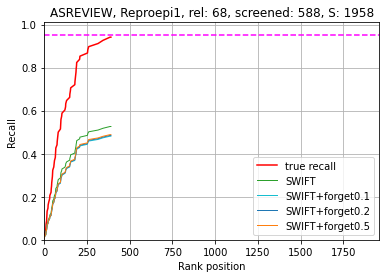

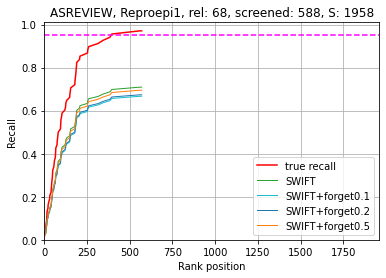

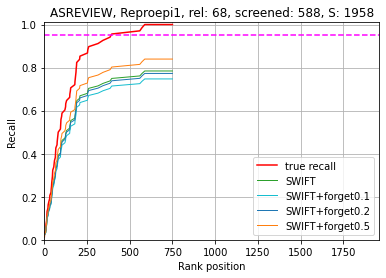

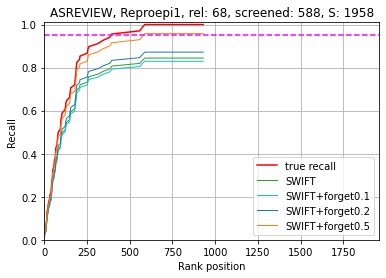

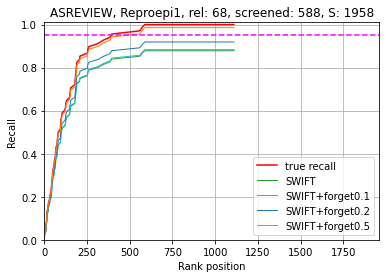

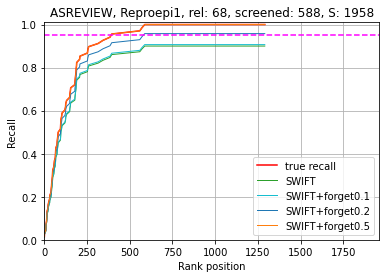

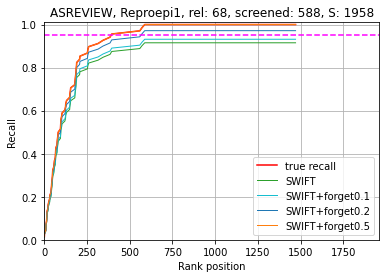

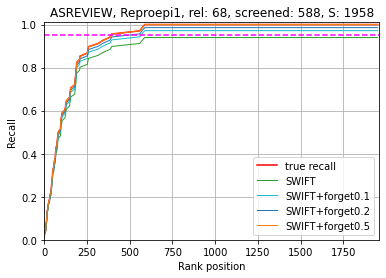

ASREVIEW, STrespCHE1, screened: 593


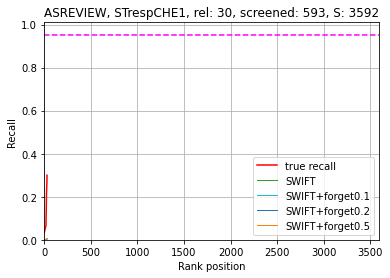

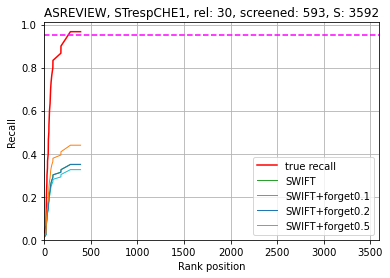

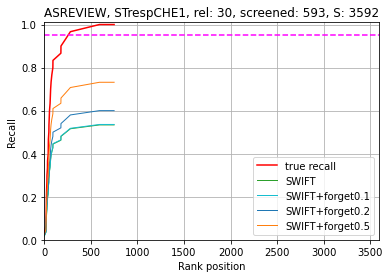

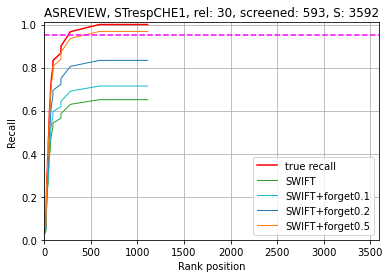

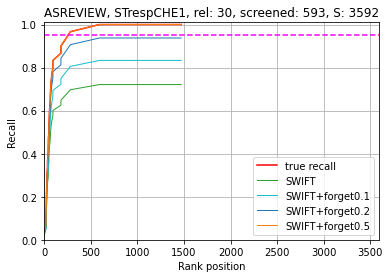

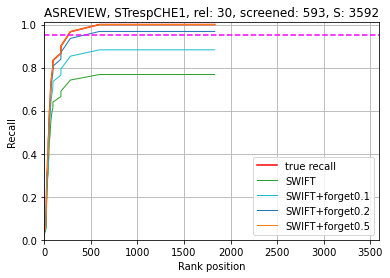

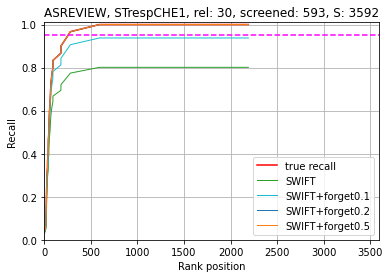

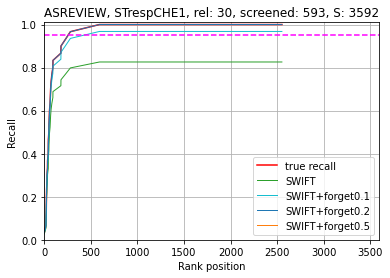

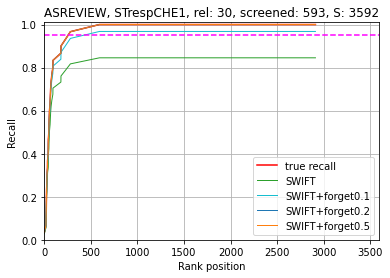

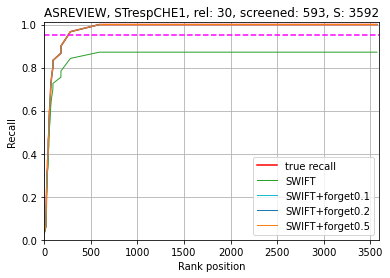

ASREVIEW, STcardioCHE1, screened: 78


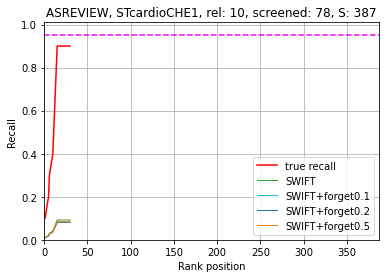

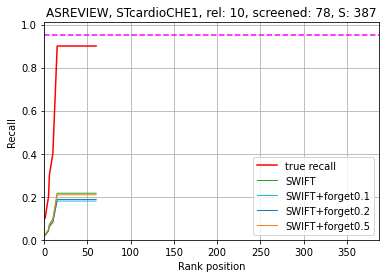

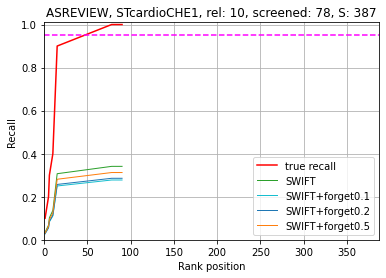

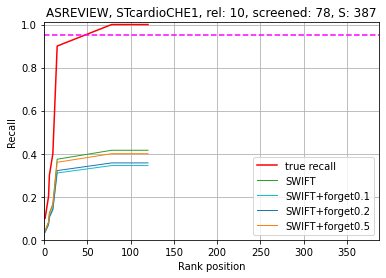

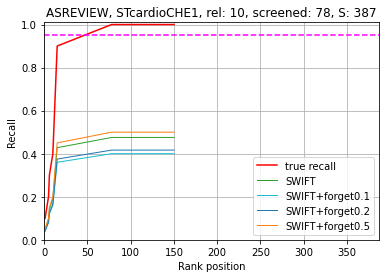

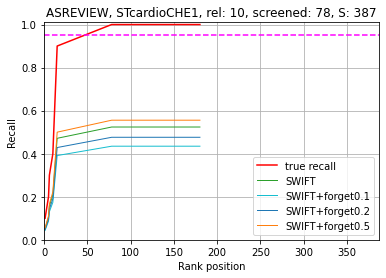

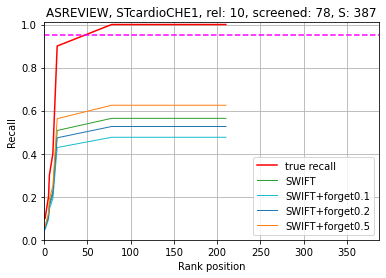

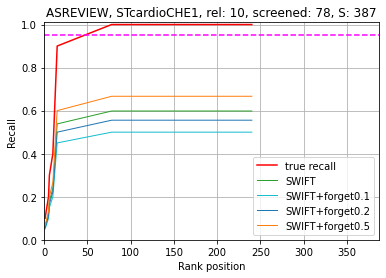

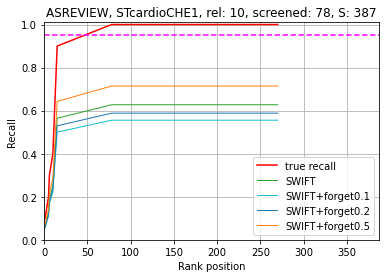

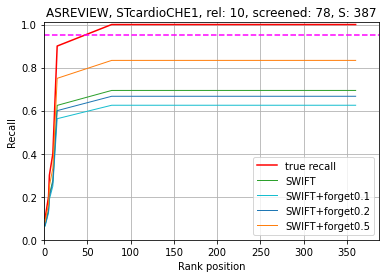

SWIFT, TerrPb2022, screened: 1826


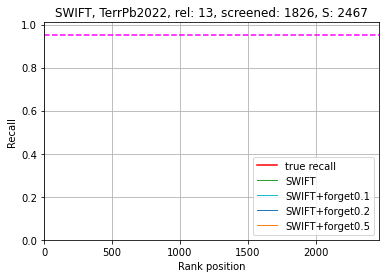

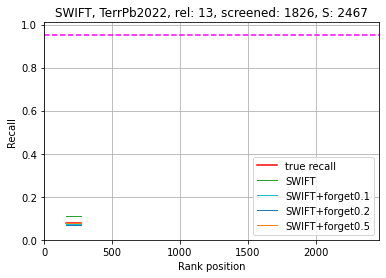

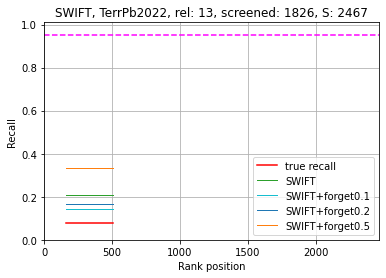

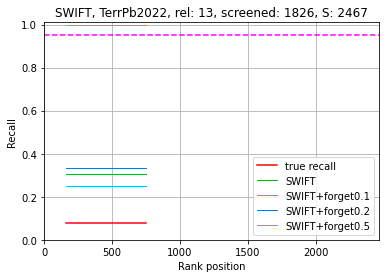

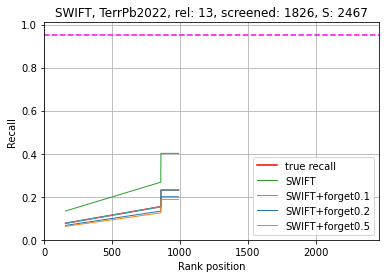

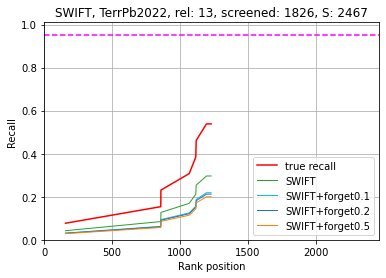

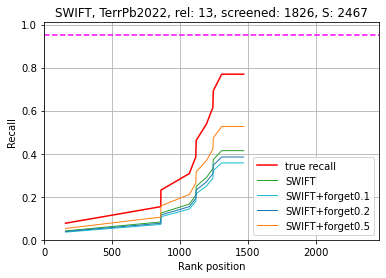

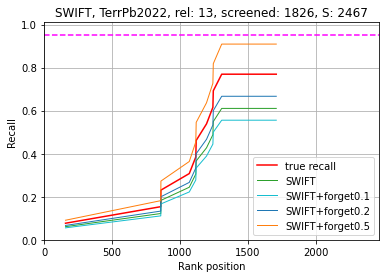

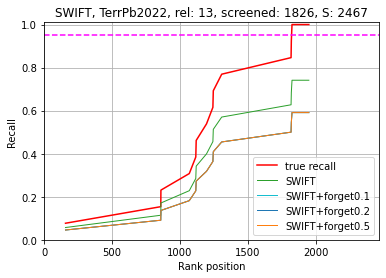

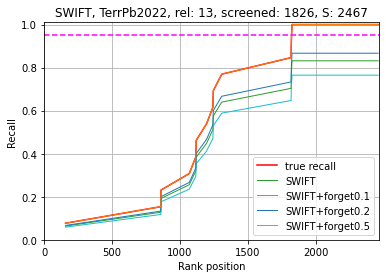

SWIFT, EpiPb2021, screened: 4213


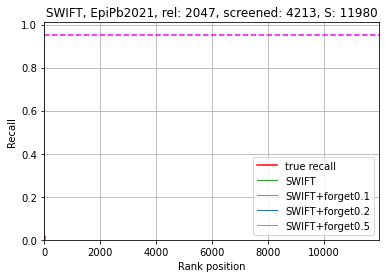

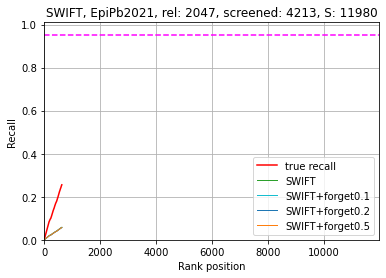

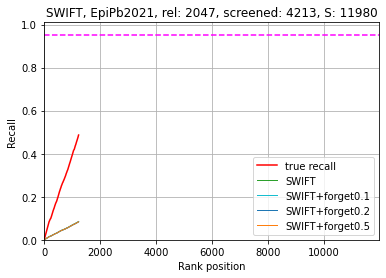

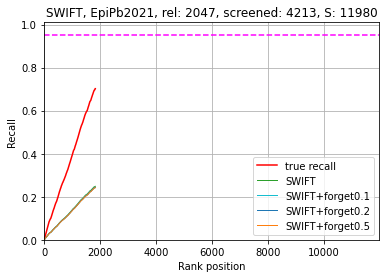

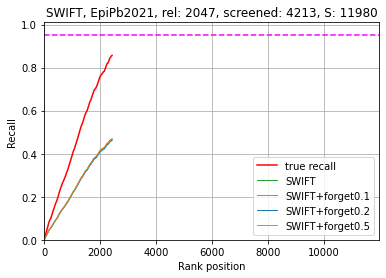

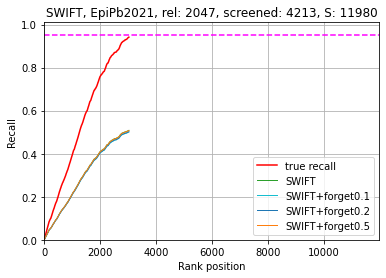

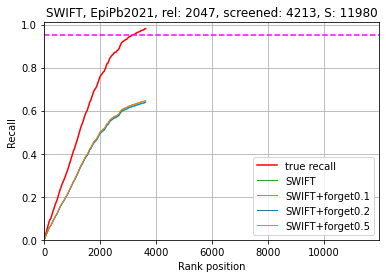

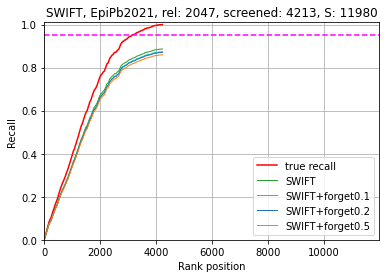

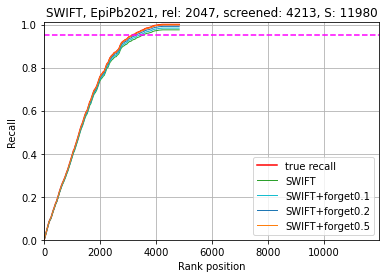

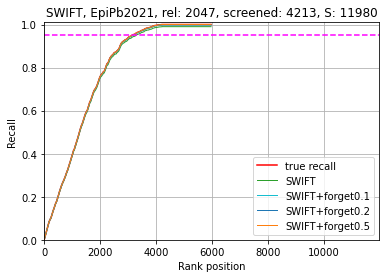

SWIFT, ExposPb2021, screened: 9340


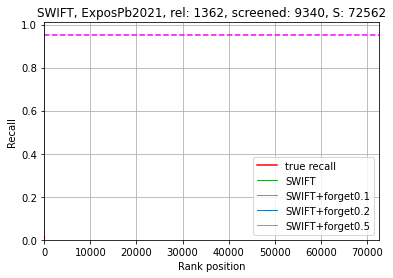

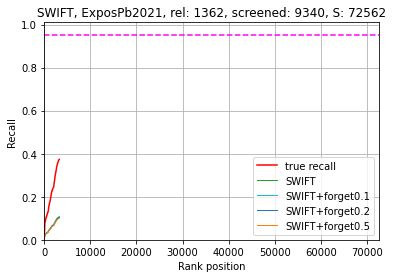

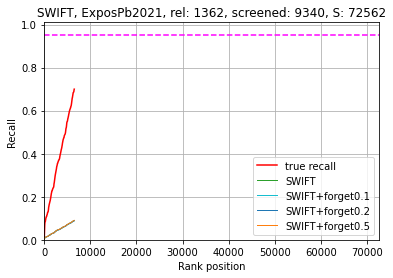

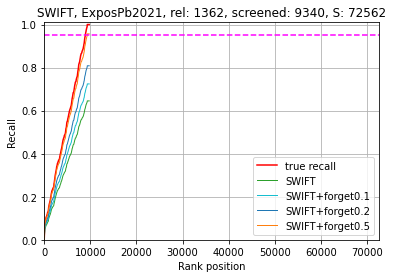

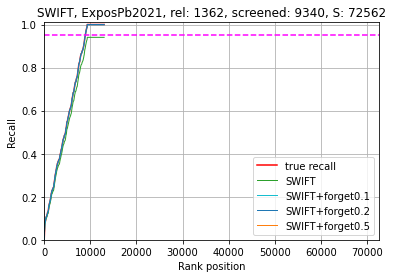

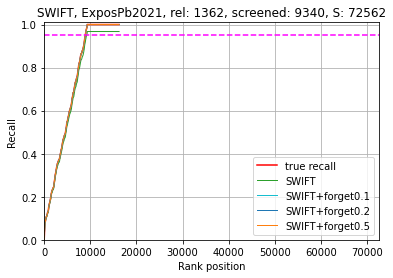

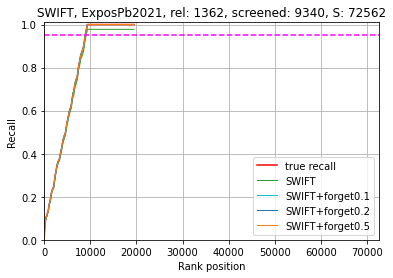

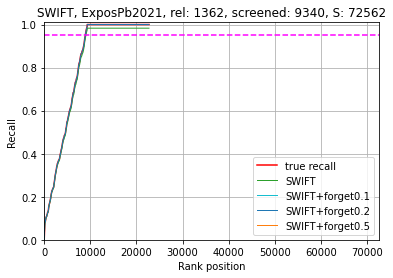

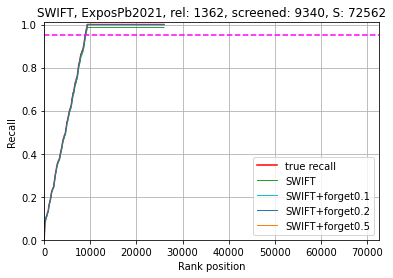

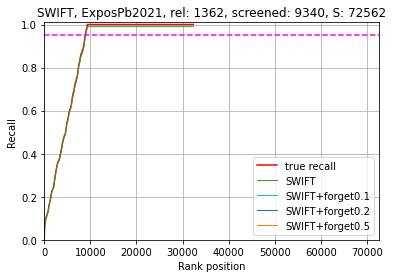

SWIFT, AquaPb2022, screened: 1688


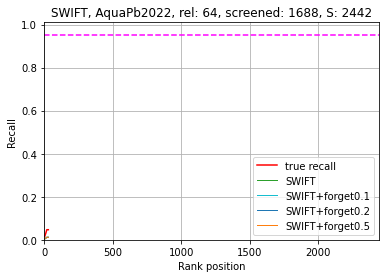

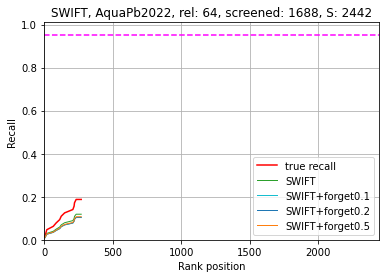

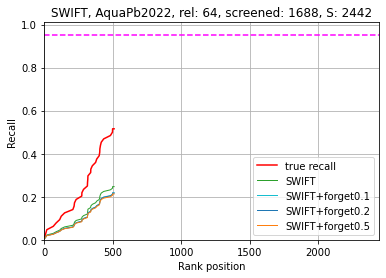

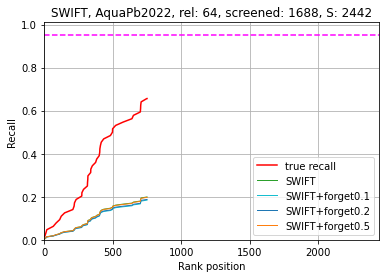

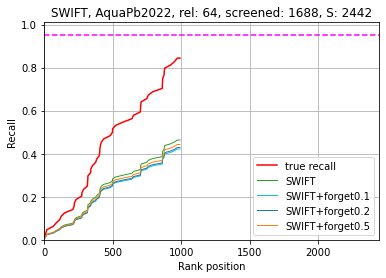

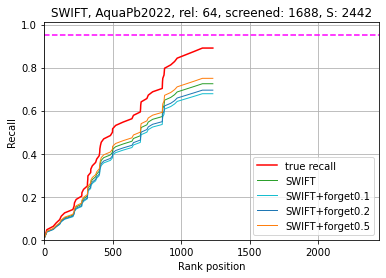

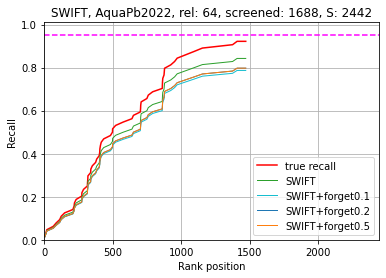

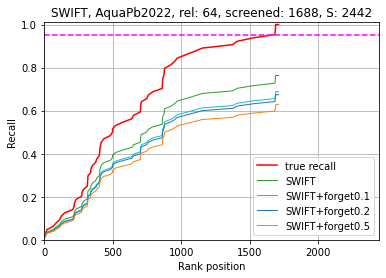

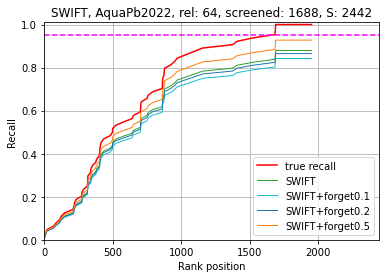

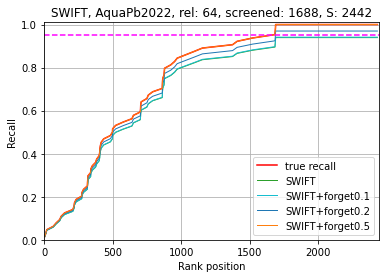

SWIFT, EpiPb2022, screened: 1074


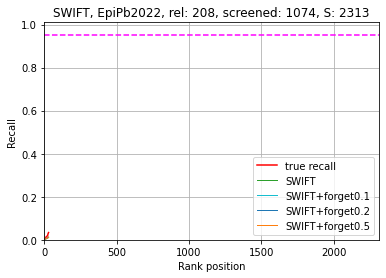

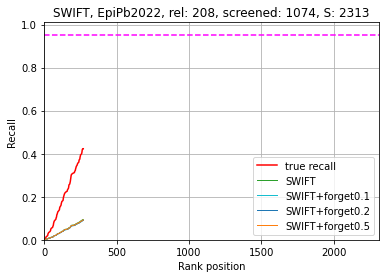

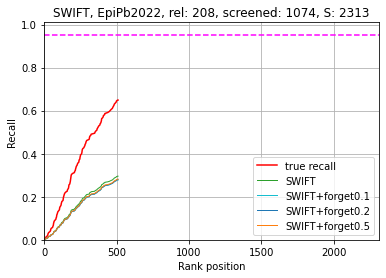

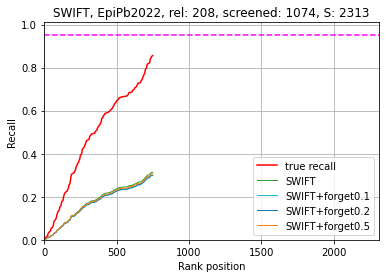

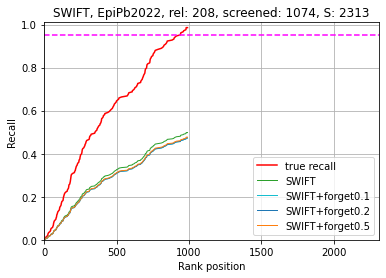

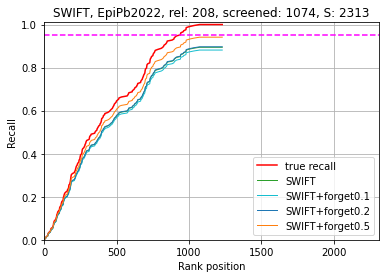

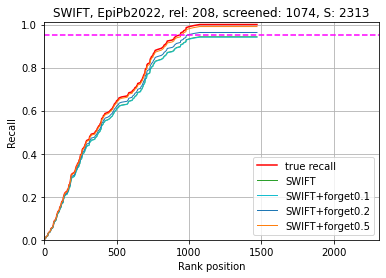

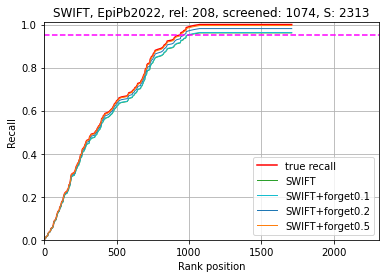

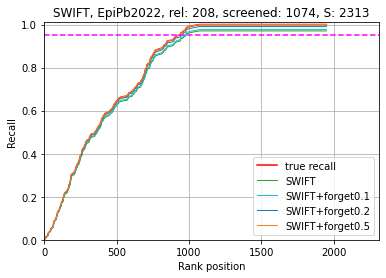

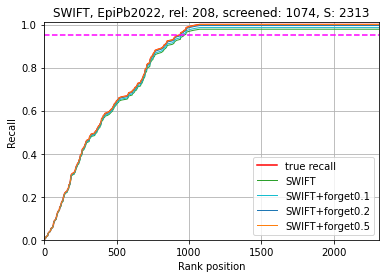

CITLINK, PM2022, screened: 554


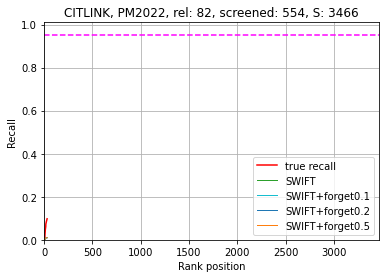

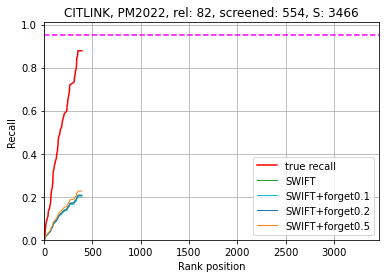

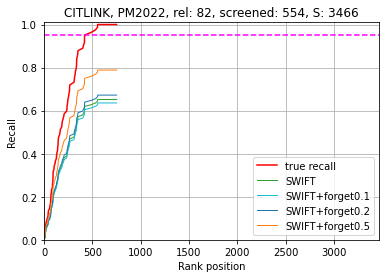

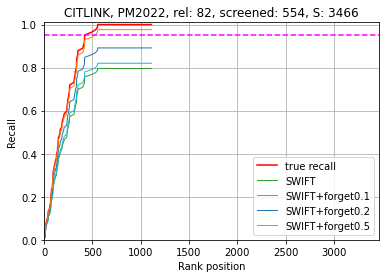

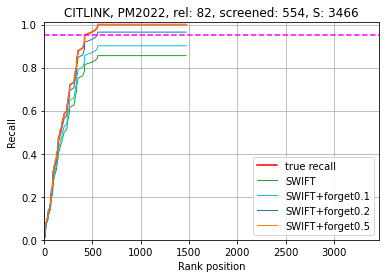

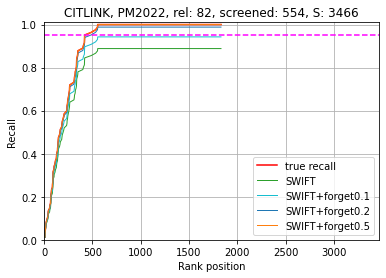

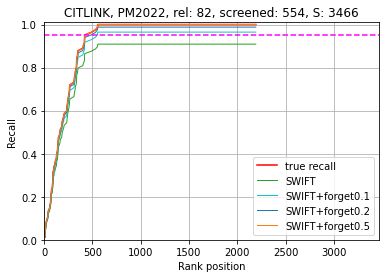

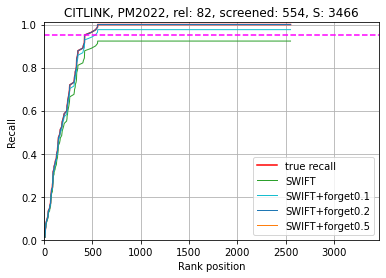

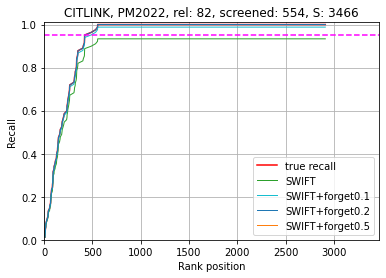

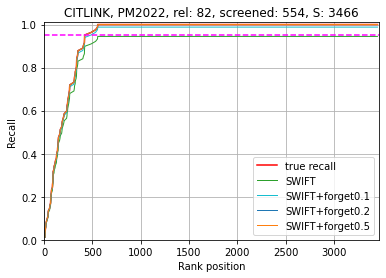

In [130]:
per_topic_data_folder = '../data/per_topic_simulation'
per_topic_output_folder = '../output/per_topic_results'

num_snapshots = 10

for file in os.listdir(per_topic_data_folder):
# for file in ['SWIFT_BiogeoPb2021_628.csv']:
    file_path = os.path.join(per_topic_data_folder, file)
    source, topic, num_screened = file.split('.')[0].split('_')
    num_screened = int(num_screened)
    rank_dataframe = pd.read_csv(file_path)
    data_path = os.path.join(per_topic_output_folder, file.replace('.csv', '.txt'))
    
    print ('{}, {}, screened: {}'.format(source, topic, num_screened))
    
    plot_path_prefix = os.path.join(per_topic_output_folder, file.replace('.csv', '_snapshot'))
    plot_recall_curves_snapshots(rank_dataframe, data_path, params, source, topic, num_screened, num_snapshots, plot_path_prefix)
    snapshot_files = [os.path.join(per_topic_output_folder, f) for f in os.listdir(per_topic_output_folder) if file.replace('.csv', '_snapshot_') in f]
    
    merger = PdfMerger()
    for pdf in sorted(snapshot_files, key = lambda x: int(x.split('_')[-1].split('.')[0])):
        merger.append(pdf)
    
    plot_path = os.path.join(per_topic_output_folder, file.replace('.csv', '_recall_curve_snapshots.pdf'))
    merger.write(plot_path)
    merger.close()
    
    for f in snapshot_files:
        os.remove(f)
    